In [93]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [94]:
df = pd.read_csv('../data/split/train.csv')

In [95]:
df.shape

(170884, 31)

In [96]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170884 entries, 0 to 170883
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    170884 non-null  float64
 1   V1      170884 non-null  float64
 2   V2      170884 non-null  float64
 3   V3      170884 non-null  float64
 4   V4      170884 non-null  float64
 5   V5      170884 non-null  float64
 6   V6      170884 non-null  float64
 7   V7      170884 non-null  float64
 8   V8      170884 non-null  float64
 9   V9      170884 non-null  float64
 10  V10     170884 non-null  float64
 11  V11     170884 non-null  float64
 12  V12     170884 non-null  float64
 13  V13     170884 non-null  float64
 14  V14     170884 non-null  float64
 15  V15     170884 non-null  float64
 16  V16     170884 non-null  float64
 17  V17     170884 non-null  float64
 18  V18     170884 non-null  float64
 19  V19     170884 non-null  float64
 20  V20     170884 non-null  float64
 21  V21     17

In [98]:
df['Class'].value_counts(normalize=True)*100

Class
0    99.821516
1     0.178484
Name: proportion, dtype: float64

The dataset is highly imbalanced, with fraudulent transactions constituting only about **0.18%** of all records, while non-fraudulent transactions make up approximately **99.82%**.
This severe imbalance suggests that applying specialized modeling techniques such as **resampling methods** or **cost-sensitive learning**, 
and exploring different approaches, may be effective in improving fraud detection performance and avoiding bias toward the majority class.


In [99]:
df.isnull().sum().sum()

np.int64(0)

In [100]:
duplicates = df[df.duplicated()]
duplicates['Class'].value_counts()


Class
0    440
1      8
Name: count, dtype: int64


> **Duplicate Rows:**
> A total of 448 duplicated rows were found in the dataset (440 normal, 8 fraud). Removing them improved F1 performance for Logistic Regression and Neural Network, but reduced performance for K-Nearest Neighbors and Random Forest. After evaluation, we chose to keep the duplicates to maintain overall ensemble performance.



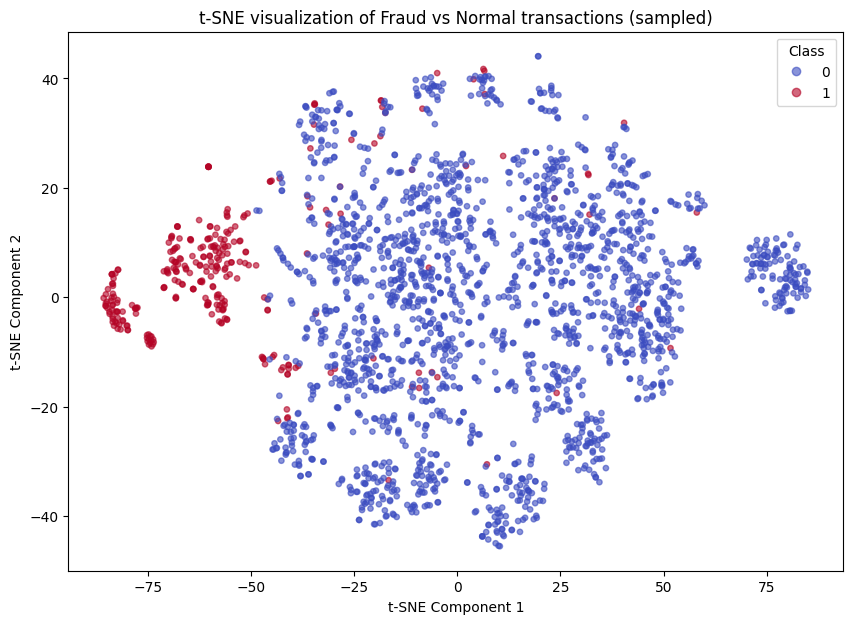

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


# Separate classes
df_fraud = df[df['Class'] == 1]
df_normal = df[df['Class'] == 0]

# Sample from normal class (e.g., 5000 points)
normal_sample = df_normal.sample(n=2000, random_state=42)

# Combine sampled normal with all fraud data
df_sampled = pd.concat([df_fraud, normal_sample])

# Separate features and target
X = df_sampled.drop(columns='Class')
y = df_sampled['Class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                      c=y, cmap='coolwarm', alpha=0.6, s=15)

plt.legend(*scatter.legend_elements(), title="Class")
plt.title("t-SNE visualization of Fraud vs Normal transactions (sampled)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


To better understand class separation, we applied t-SNE (t-distributed Stochastic Neigh-
bor Embedding) on a subset of the data created by randomly undersampling the majority
(normal) class. Directly applying t-SNE on the full dataset would obscure class structure
due to extreme imbalance.
The visualization reveals two distinct clusters, with fraudulent transactions partially overlapping the larger cluster of legitimate ones. This indicates that some fraud cases exhibit
patterns similar to normal behavior, making them harder to detect. As a result, oversampling methods like SMOTE may inadvertently generate synthetic fraud samples in these
overlapping regions, introducing noise and reducing model reliability.

In [102]:
def show_fraud_normal_stat(feature: str):
    fraud_stats = df[df['Class'] == 1][feature].describe()
    normal_stats = df[df['Class'] == 0][feature].describe()
    
    stats_df = pd.concat([fraud_stats, normal_stats], axis=1)
    stats_df.columns = ['Fraud', 'Normal']
    
    print(f'\nDescriptive Statistics for "{feature}"\n')
    print(stats_df)



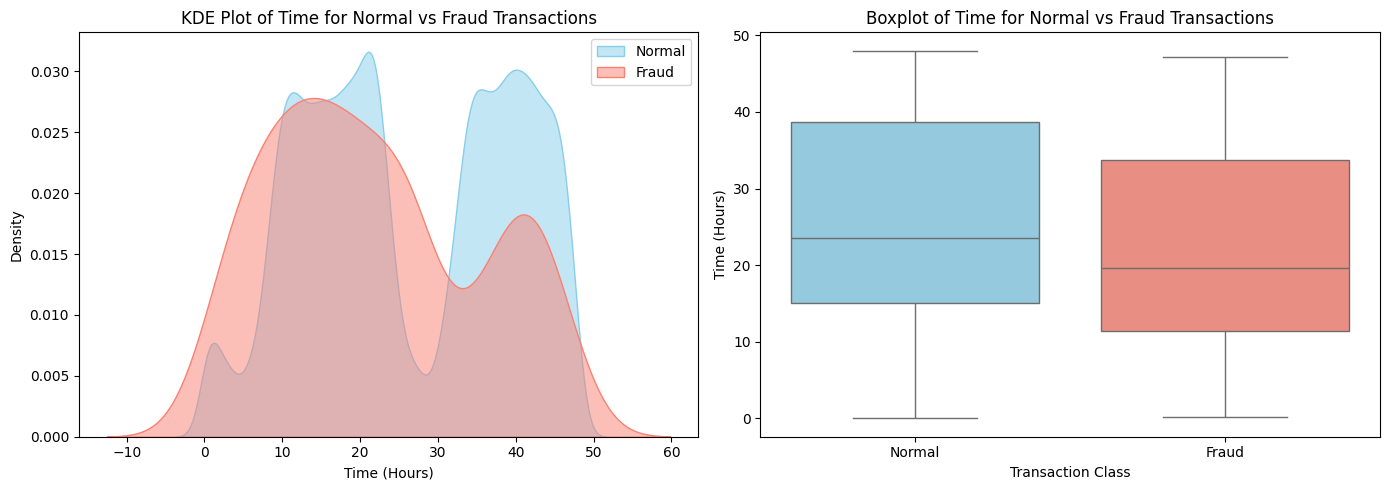


Descriptive Statistics for "Time"

            Fraud         Normal
count  305.000000  170579.000000
mean    21.891536      26.387499
std     13.236030      13.183224
min      0.112778       0.000000
25%     11.453611      15.102917
50%     19.593333      23.596667
75%     33.677222      38.728611
max     47.212778      47.997778


In [103]:
df['Time'] = df['Time'] / 3600  # Convert seconds to hours

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KDE Plot
sns.kdeplot(df[df['Class'] == 0]['Time'], label='Normal', fill=True, alpha=0.5, color='skyblue', ax=axes[0])
sns.kdeplot(df[df['Class'] == 1]['Time'], label='Fraud', fill=True, alpha=0.5, color='salmon', ax=axes[0])
axes[0].set_title('KDE Plot of Time for Normal vs Fraud Transactions')
axes[0].set_xlabel('Time (Hours)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Boxplot (with updated hue and palette)
sns.boxplot(x='Class', y='Time', data=df, hue='Class', palette={0: 'skyblue', 1: 'salmon'}, ax=axes[1], legend=False)
axes[1].set_title('Boxplot of Time for Normal vs Fraud Transactions')
axes[1].set_xlabel('Transaction Class')
axes[1].set_ylabel('Time (Hours)')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.show()

show_fraud_normal_stat('Time')


* The KDE plot shows overlapping, multi-modal distributions for normal and fraud transactions, with fraud times more spread out and peaking at different intervals.
* The median and interquartile range for fraud transactions are slightly lower but more variable than normal ones, with fraud having more extreme outliers.
* Overall, "Time" alone is a weak predictor due to significant overlap and noise.
* Empirical testing found that including "Time" without special handling reduced model performance.
* However, when using NearMiss undersampling to address imbalance, the "Time" feature became important and improved fraud detection.



In [104]:
show_fraud_normal_stat('Amount')


Descriptive Statistics for "Amount"

             Fraud         Normal
count   305.000000  170579.000000
mean    126.747738      88.443356
std     253.341868     256.738807
min       0.000000       0.000000
25%       1.000000       5.680000
50%      12.310000      22.040000
75%     111.700000      77.500000
max    1504.930000   25691.160000


* The `Amount` feature is **highly right-skewed**, with extreme outliers—particularly in normal transactions (max = \$25,691).
* **Fraud transactions** have a **higher median (\$12.31  vs. \$22.04)** but a **lower mean**, suggesting fewer large-value outliers than normal transactions.
* **Normal transactions** exhibit more variability and higher-value extremes.
* Due to this skew, **log transformation** was applied to stabilize variance and make the distribution more suitable for modeling.


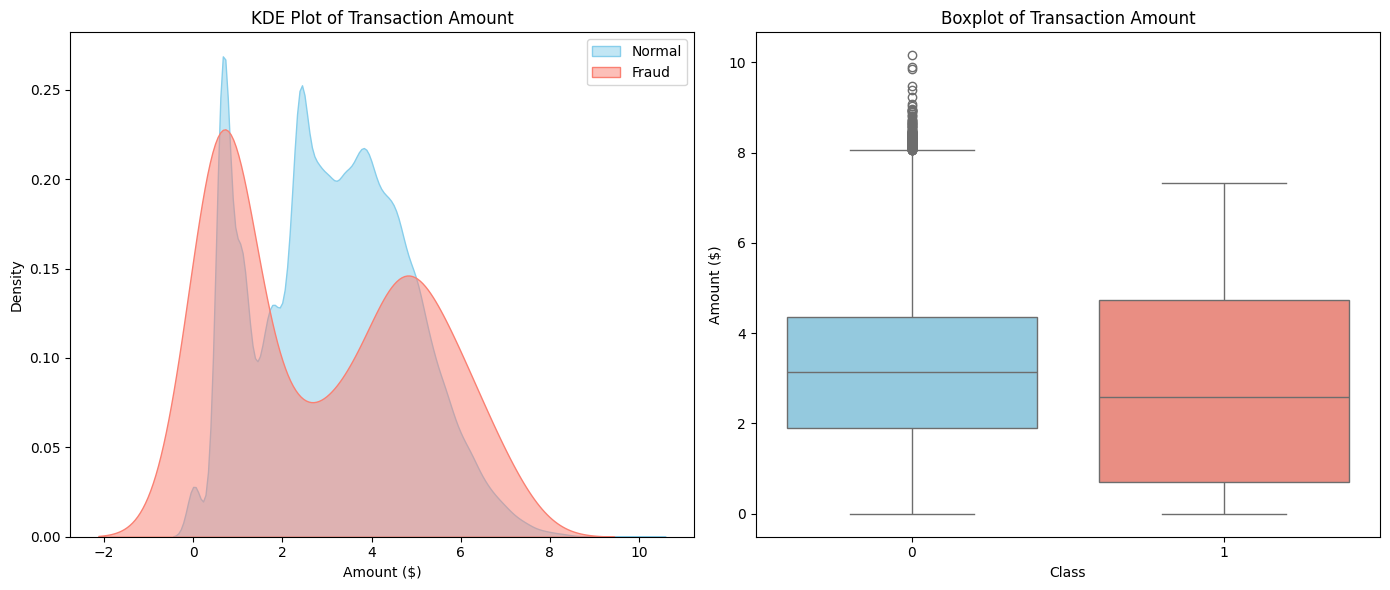

In [105]:
df['Amount'] = np.log1p(df['Amount'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KDE Plot
sns.kdeplot(
    df[df['Class'] == 0]['Amount'], label='Normal',
    fill=True, alpha=0.5, color='skyblue', ax=axes[0]
)
sns.kdeplot(
    df[df['Class'] == 1]['Amount'], label='Fraud',
    fill=True, alpha=0.5, color='salmon', ax=axes[0]
)
axes[0].set_title('KDE Plot of Transaction Amount')
axes[0].set_xlabel('Amount ($)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Boxplot (with mapped labels)
sns.boxplot(data=df, x='Class', y='Amount', hue='Class', palette=['skyblue', 'salmon'], ax=axes[1], legend=False)
axes[1].set_title('Boxplot of Transaction Amount')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Amount ($)')

plt.tight_layout()
plt.show()

* The original `Amount` feature exhibited a **strong right skew**, heavily influenced by extreme outliers.
* Applying a **log transformation** successfully corrected this skew, producing a **more symmetric distribution** that is better suited for modeling.
* **Fraudulent transactions** generally involve **lower amounts** but show greater variability.
* In contrast, **non-fraudulent transactions** display a wider range of amounts, with a higher median and more extreme high-value outliers.
* KDE plots and boxplots highlight **distinct distributional patterns** between the fraud and normal classes, underscoring their differences.


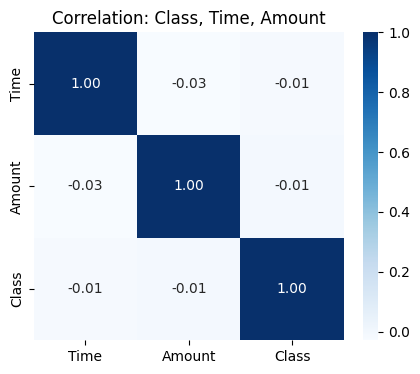

In [106]:
# Compute correlation matrix for Class, Time, and Amount
corr_subset = df[['Time', 'Amount','Class']].corr()

# Plot heatmap with softer colors
plt.figure(figsize=(5, 4))
sns.heatmap(corr_subset, annot=True, cmap='Blues', fmt=".2f")  # using a softer blue color map
plt.title("Correlation: Class, Time, Amount")
plt.show()




> The features `Time` and `Amount` exhibit **negligible linear correlation with the target variable `Class`**, with correlation coefficients of -0.014 and -0.007 respectively. This suggests that fraud is not linearly associated with either transaction time or amount. However, linear correlation alone is not a sufficient indicator of feature importance — these features may still provide predictive value in non-linear models or in combination with other variables. For example, frauds may cluster around specific time windows or exhibit extreme transaction amounts, patterns which linear correlation does not capture.




For the features **V1 to V28**, since their exact meanings are unknown due to anonymization, we rely on **data-driven methods** to guide feature engineering. One useful strategy is to use **Random Forest feature importance** to identify which features have the greatest impact on model performance—this helps us decide where to focus further engineering or analysis efforts. Additionally, the **correlation matrix** can serve as a helpful indicator of relationships or redundancy between features. However, it's important to **resample the majority class first** (using techniques like undersampling or oversampling), because the extreme class imbalance can hide subtle differences in distributions and make it difficult to spot meaningful correlations.


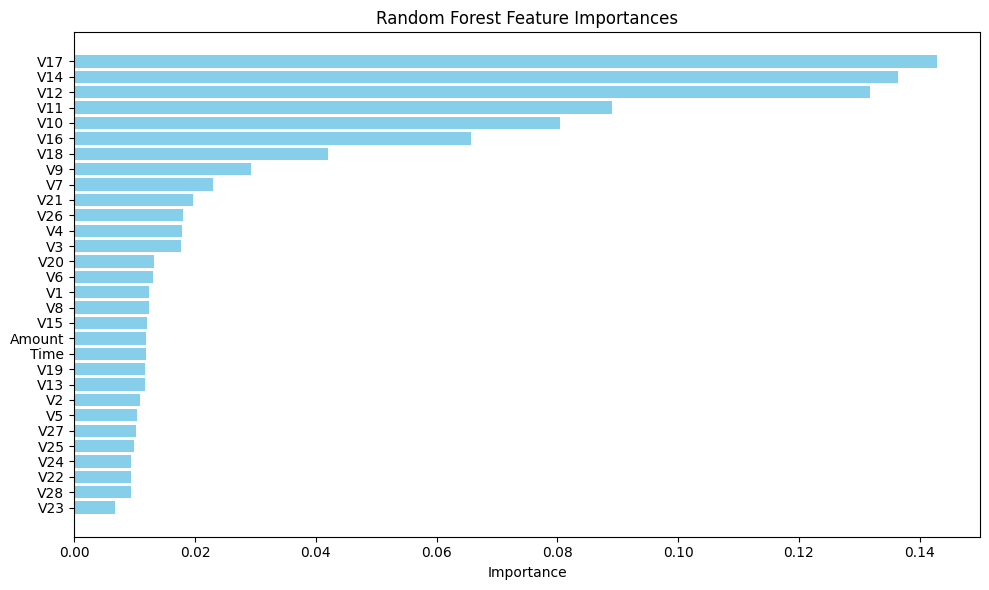

In [107]:
import joblib

# === Load the model ===
bundle = joblib.load('../saved_models/rf_feature_importance_model.pkl') 
model = bundle['pipeline']['model']

# === Feature names (if available) ===

feature_names = [col for col in df.columns if col != 'Class']

# === Get importances ===
importances = model.feature_importances_

# === Create a DataFrame for better visualization ===
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Most important on top
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


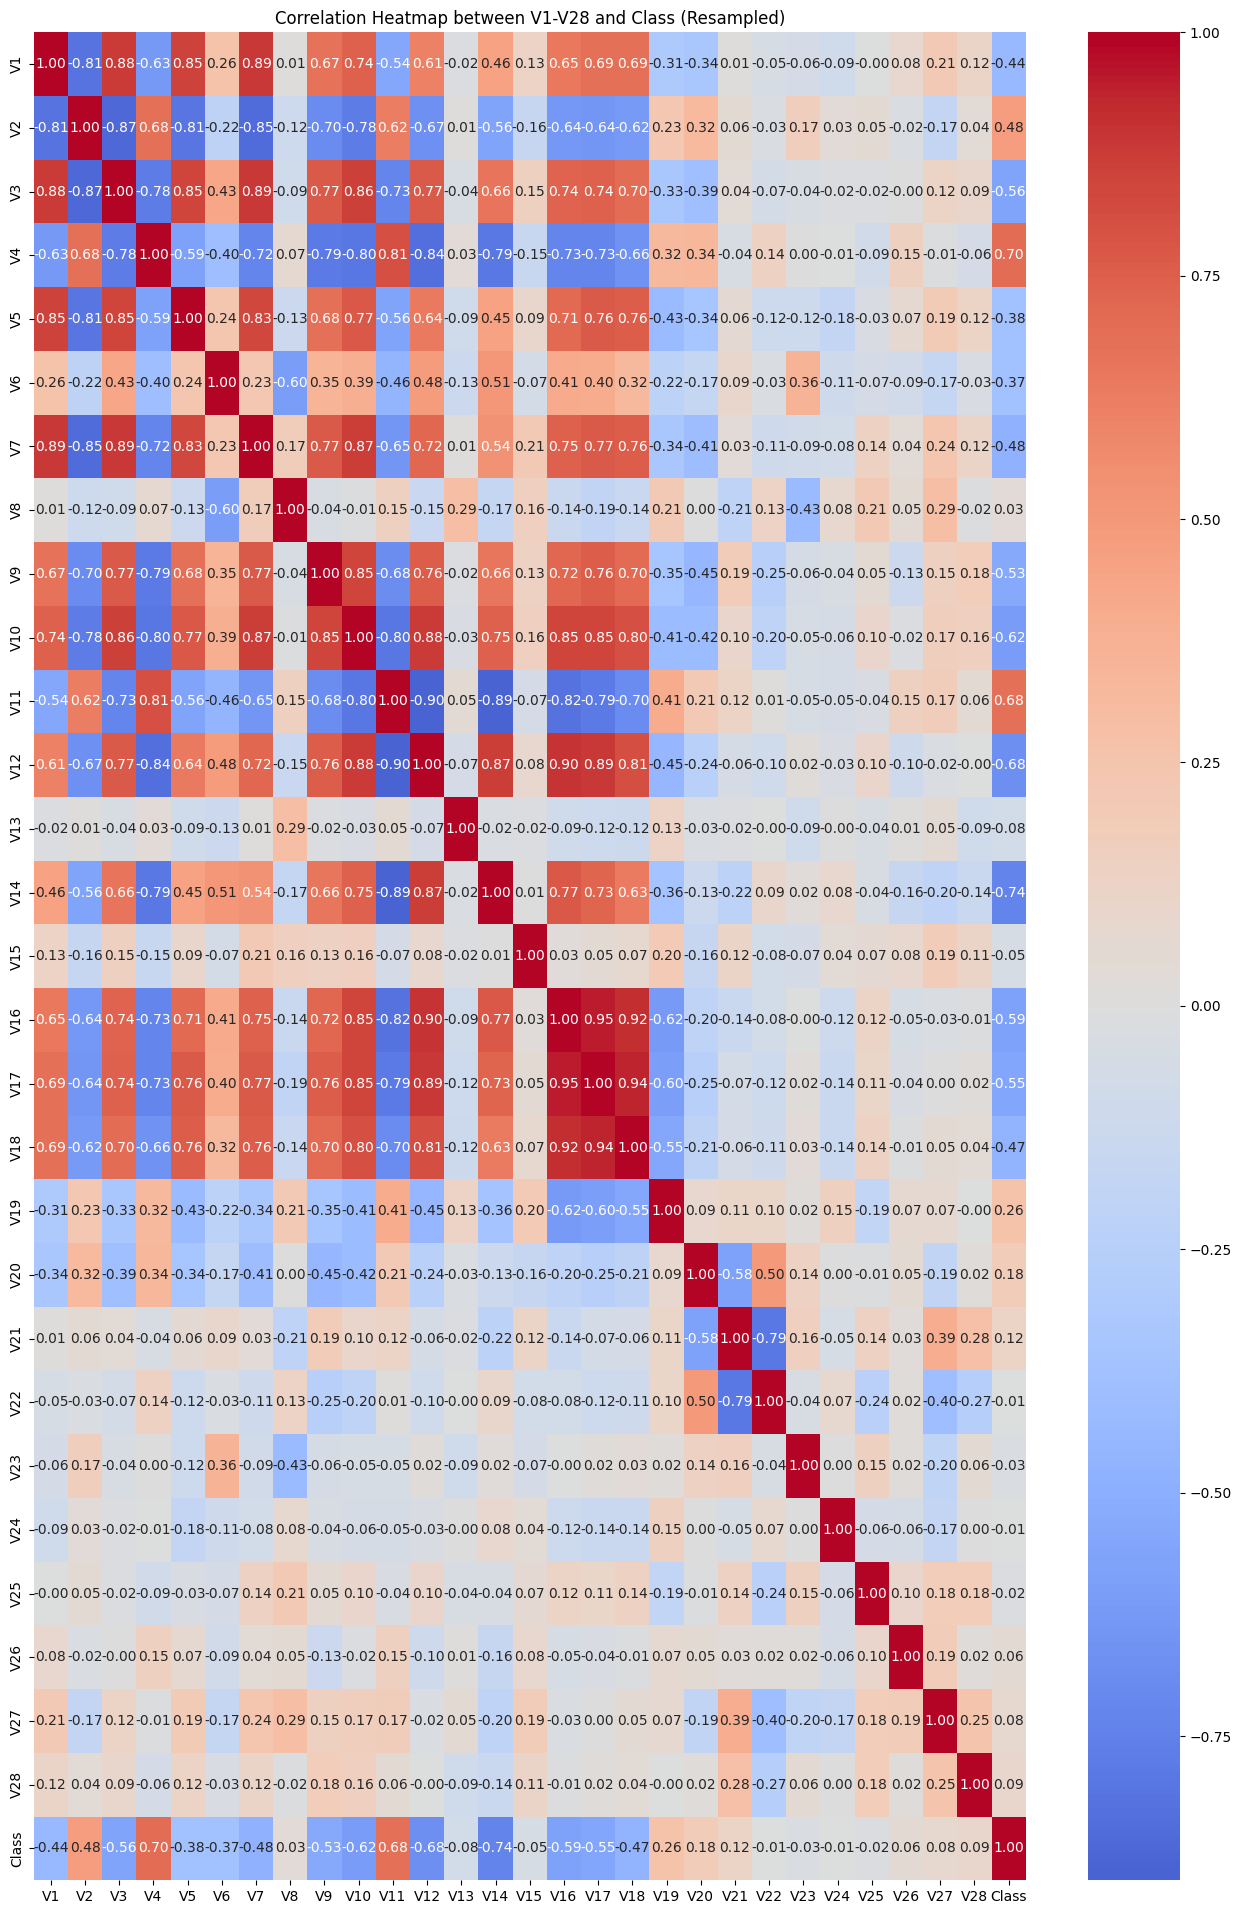

In [108]:
from imblearn.under_sampling import RandomUnderSampler

def plot_correlation_heatmap_resampled(df, sampler=None):
    features = [f'V{i}' for i in range(1, 29)] + ['Class']
    
    X = df[features].drop('Class', axis=1)
    y = df['Class']
    
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X, y)
        df_resampled = X_res.copy()
        df_resampled['Class'] = y_res
    else:
        df_resampled = df[features]

    corr = df_resampled.corr()

    plt.figure(figsize=(16, 24))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap between V1-V28 and Class (Resampled)')
    plt.show()

# Example usage with undersampling:
rus = RandomUnderSampler(random_state=42)
plot_correlation_heatmap_resampled(df, sampler=rus)


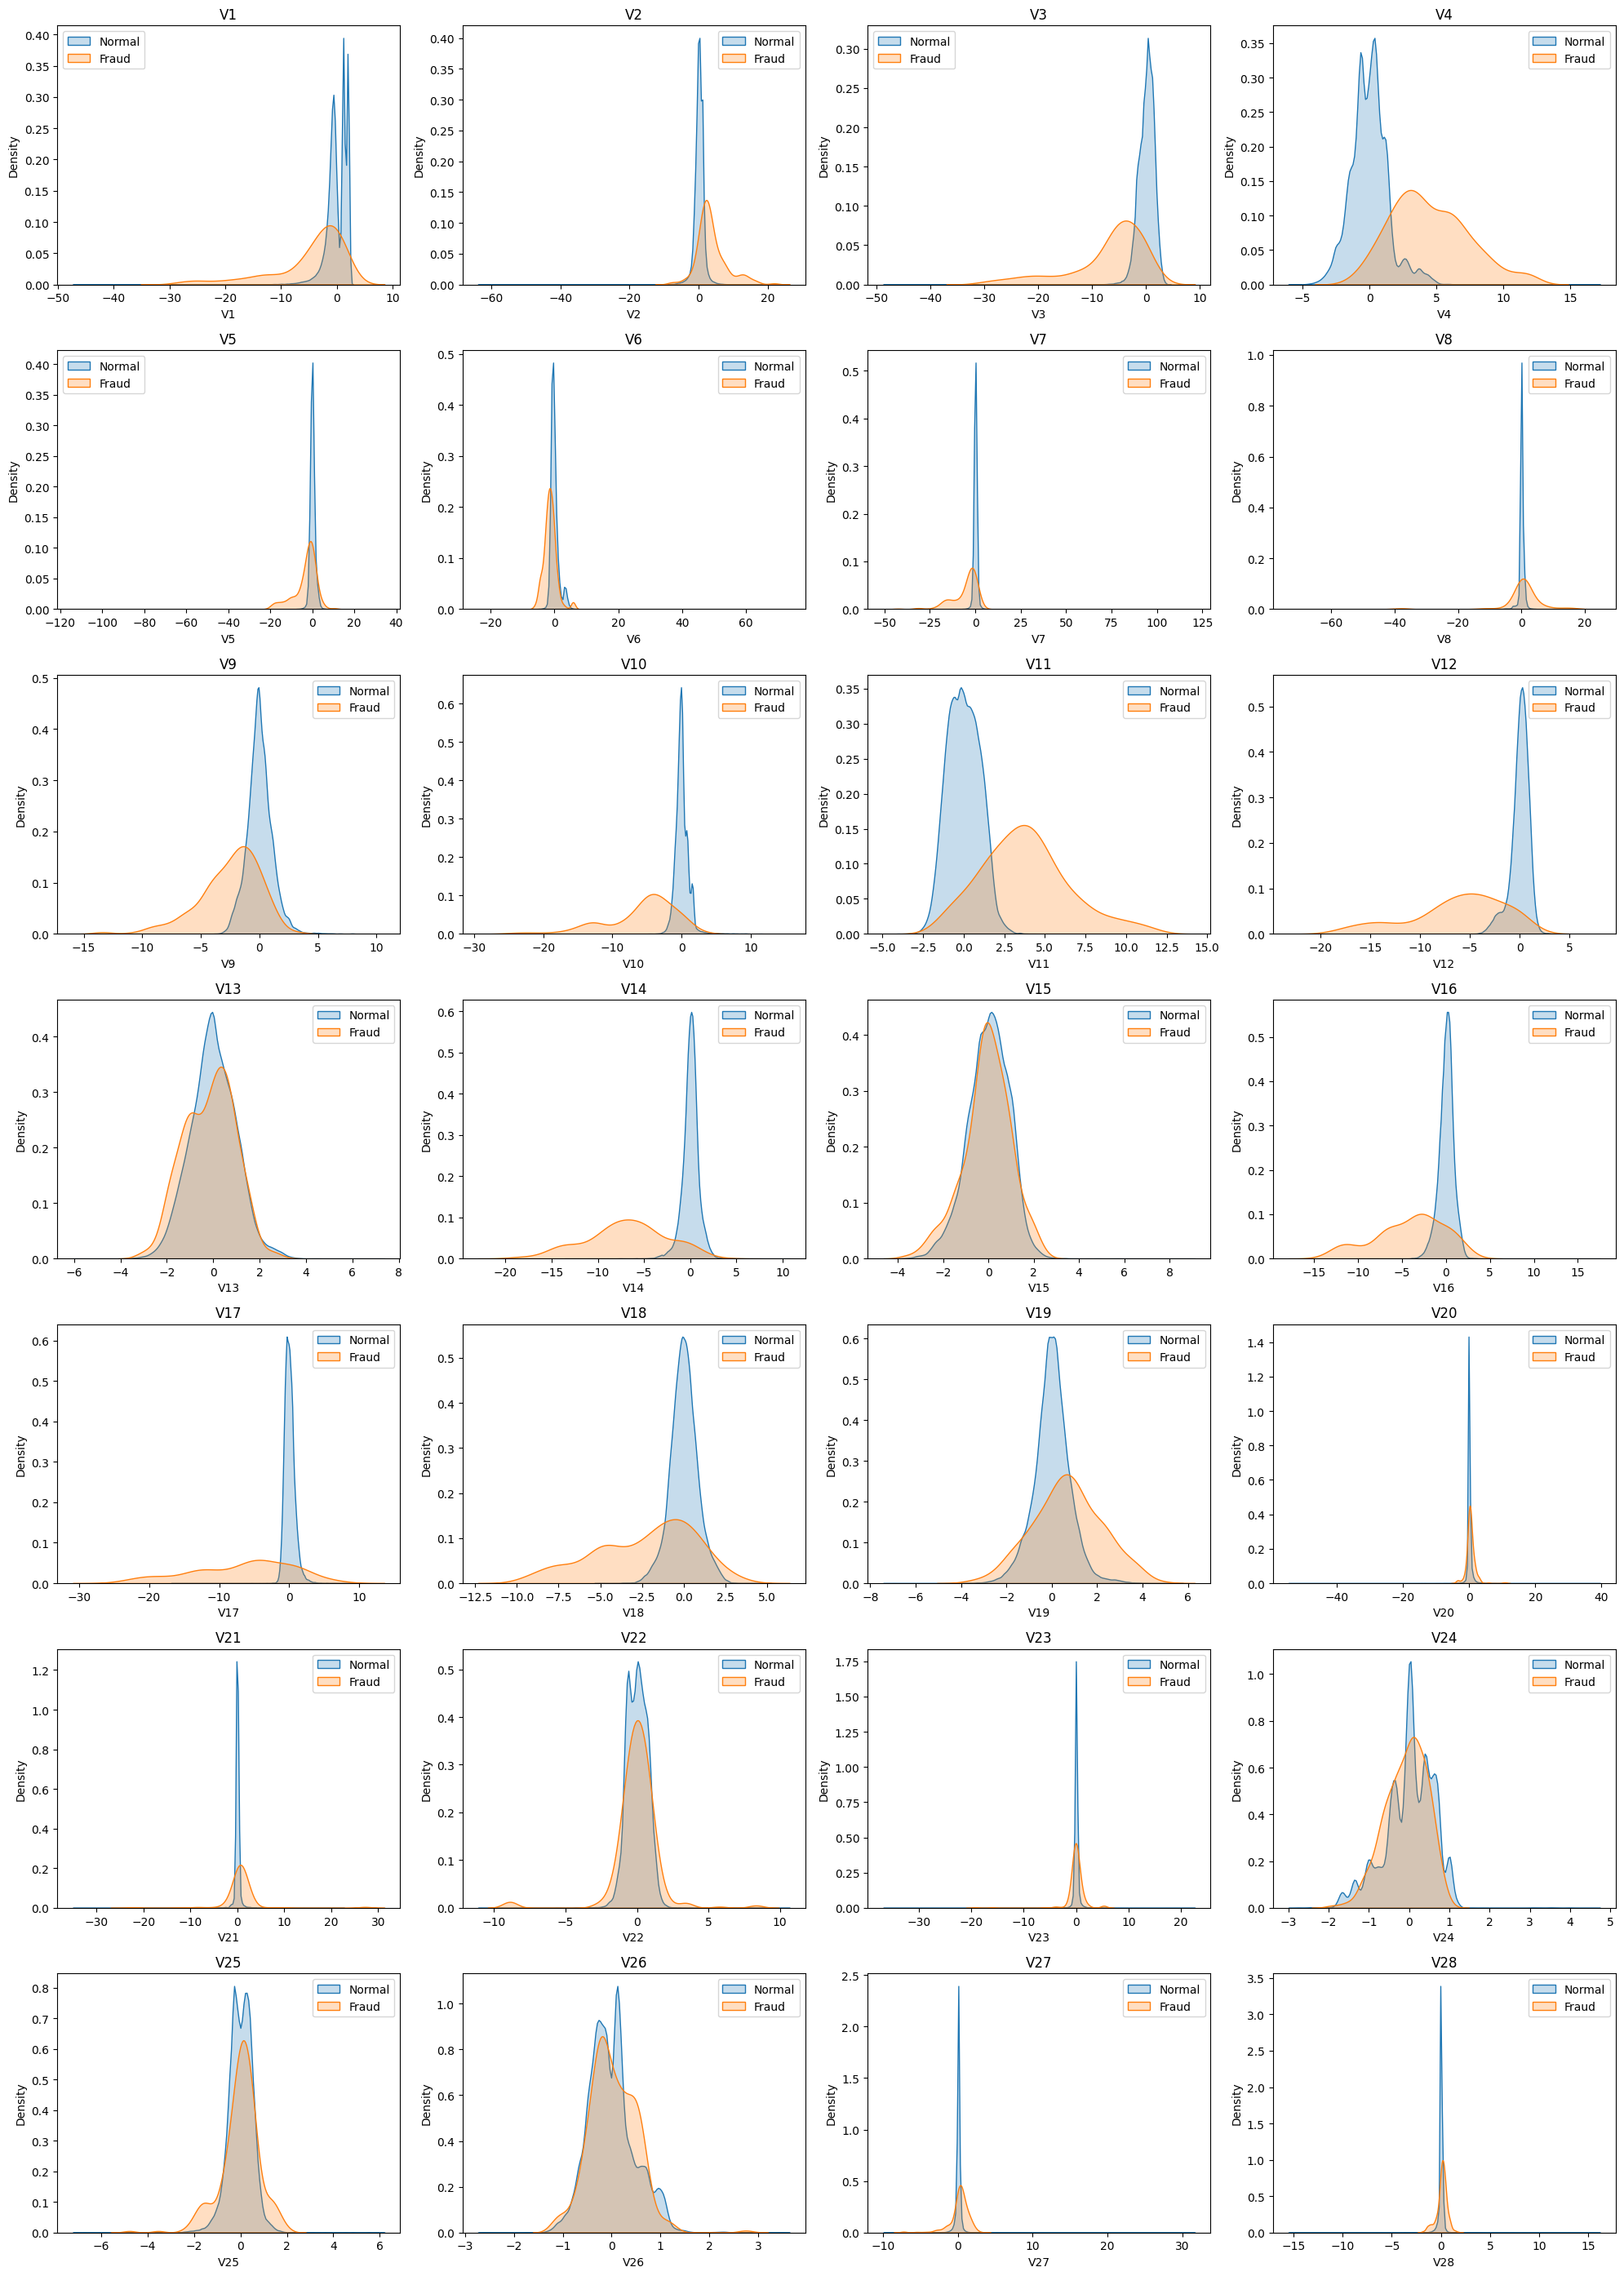

In [109]:
def plot_all_kdes_together(df):
    features = [f'V{i}' for i in range(1, 29)]
    n_cols = 4
    n_rows = (len(features) + n_cols - 1) // n_cols  # calculate rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.kdeplot(data=df[df['Class'] == 0], x=feature, label='Normal', fill=True, ax=axes[i])
        sns.kdeplot(data=df[df['Class'] == 1], x=feature, label='Fraud', fill=True, ax=axes[i])
        axes[i].set_title(feature)
        axes[i].legend()

    # Hide any extra subplots if features < n_rows*n_cols
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_all_kdes_together(df)
